In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 
from datetime import datetime,time

In [2]:
data = pd.read_excel("Airlines+Data.xlsx")

In [3]:
data.head()

,Month,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [4]:
#data["month"] = data.Month.dt.strftime("%b")
data['Month'] = pd.to_datetime(data['Month'],infer_datetime_format=True)
indexedDataset = data.set_index(['Month'])

In [5]:
indexedDataset.head()

,Passengers
Month,
1995-01-01,112
1995-02-01,118
1995-03-01,132
1995-04-01,129
1995-05-01,121


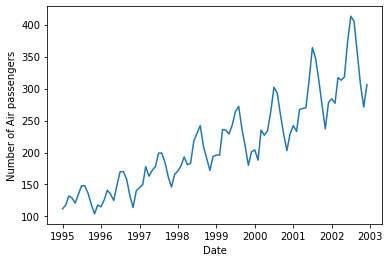

In [6]:
plt.xlabel('Date')
plt.ylabel('Number of Air passengers')
plt.plot(indexedDataset)

In [7]:
#Determining rolling statistics
rolmean = indexedDataset.rolling(window=12).mean()

rolstd = indexedDataset.rolling(window=12).std()
print(rolmean,rolstd)

            Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01  316.833333
2002-09-01  320.416667
2002-10-01  323.083333
2002-11-01  325.916667
2002-12-01  328.250000

[96 rows x 1 columns]             Passengers
Month                 
1995-01-01         NaN
1995-02-01         NaN
1995-03-01         NaN
1995-04-01         NaN
1995-05-01         NaN
...                ...
2002-08-01   54.530781
2002-09-01   55.586883
2002-10-01   53.899668
2002-11-01   49.692616
2002-12-01   47.861780

[96 rows x 1 columns]


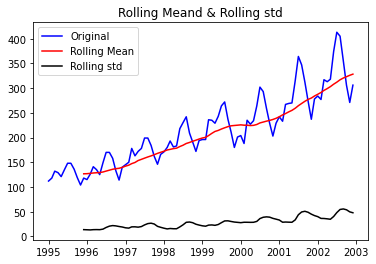

In [8]:
#plot rolling statistics
orig = plt.plot(indexedDataset,color='blue',label='Original')
mean = plt.plot(rolmean, color='red',label='Rolling Mean')
std = plt.plot(rolstd, color = 'black',label = 'Rolling std')
plt.legend(loc='best')
plt.title('Rolling Meand & Rolling std')
plt.show(block=False)

In [9]:
#perform Dickey-fuller test:
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey fuller test:')
dftest = adfuller(indexedDataset['Passengers'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key]= value
    
print(dfoutput)    

Results of Dickey fuller test:
Test Statistic                  1.340248
p-value                         0.996825
#Lags Used                     12.000000
Number of Observations Used    83.000000
Critical Value (1%)            -3.511712
Critical Value (5%)            -2.897048
Critical Value (10%)           -2.585713
dtype: float64


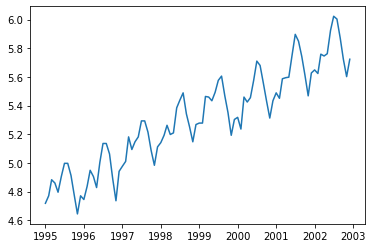

In [10]:
#Estimating trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

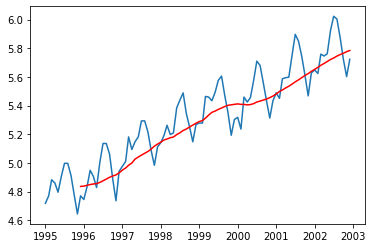

In [11]:
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [12]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove Nan values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)

In [13]:
datasetLogScaleMinusMovingAverage.head()

,Passengers
Month,
1995-12-01,-0.065494
1996-01-01,-0.093449
1996-02-01,-0.007566
1996-03-01,0.099416
1996-04-01,0.052142


In [20]:
def test_stationary(timeseries):
    
    #Determining rolling statistics
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()
    
    #plot rolling statistics
    orig = plt.plot(timeseries,color='blue',label='Original')
    mean = plt.plot(movingAverage,color='red',label='Rolling Mean')
    std = plt.plot(movingSTD,color='black',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print('Results of Dickey fuller test:')
    dftest = adfuller(timeseries['Passengers'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key]= value
    
    print(dfoutput) 
    

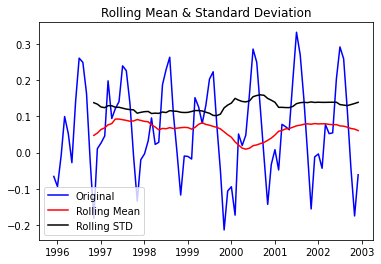

Results of Dickey fuller test:
Test Statistic                 -1.910930
p-value                         0.326937
#Lags Used                     12.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


In [21]:
test_stationary(datasetLogScaleMinusMovingAverage)

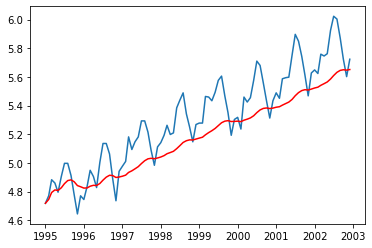

In [22]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

In [23]:
datasetLogScaleMinusMovingExponentDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage

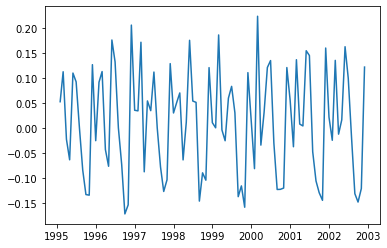

In [24]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

In [25]:
datasetLogDiffShifting.dropna(inplace=True)

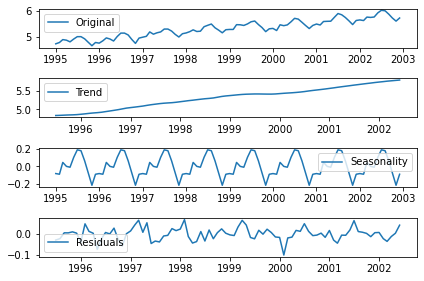

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal= decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(indexedDataset_logScale,label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decompositionLogData = residual
decompositionLogData.dropna(inplace = True)







In [27]:
decompositionLogData = residual
decompositionLogData.dropna(inplace=True)


C:\Users\91890\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


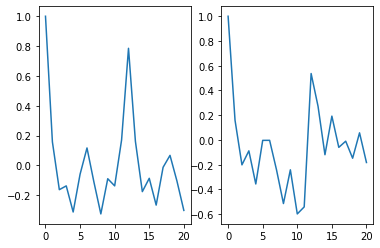

In [28]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetLogDiffShifting,nlags=20)
lag_pacf = pacf(datasetLogDiffShifting,nlags=20,method='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)


#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)




C:\Users\91890\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\91890\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS wi

plotting AR Model


C:\Users\91890\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


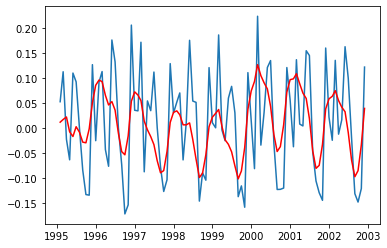

In [29]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logScale,order=(2,1,2))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
print('plotting AR Model')

In [30]:
predictions_ARIMA_diff = pd.Series(results_AR.fittedvalues, copy=True)

In [31]:
#convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()


In [32]:
predictions_ARIMA_log = pd.Series(indexedDataset_logScale['Passengers'].iloc[0], index =indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)

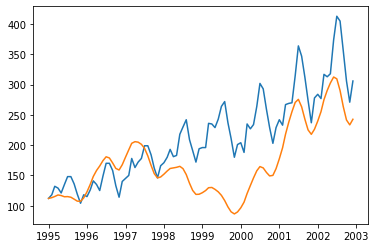

In [33]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

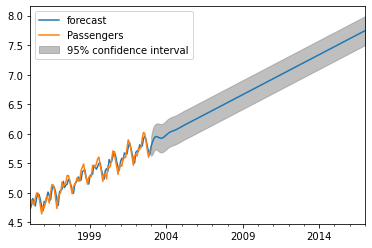

In [34]:
results_AR.plot_predict(1,264)
x=results_AR.forecast(steps=120)

In [35]:
x[1]

array([0.08321671, 0.10429996, 0.10874541, 0.10874925, 0.11126375,
       0.11614218, 0.1202422 , 0.12204987, 0.12229638, 0.12235836,
       0.12287242, 0.12360204, 0.12411486, 0.12429059, 0.12429863,
       0.12432841, 0.12442677, 0.12453442, 0.12459562, 0.12461012,
       0.12461014, 0.12461899, 0.12463657, 0.12465191, 0.12465888,
       0.12465987, 0.12466008, 0.12466198, 0.12466469, 0.12466659,
       0.12466722, 0.12466724, 0.12466738, 0.1246678 , 0.12466826,
       0.12466852, 0.12466859, 0.12466859, 0.12466862, 0.12466867,
       0.12466872, 0.12466874, 0.12466874, 0.12466874, 0.12466875,
       0.12466877, 0.12466878, 0.12466879, 0.12466879, 0.12466879,
       0.12466879, 0.12466879, 0.12466879, 0.12466879, 0.12466879,
       0.12466879, 0.1246688 , 0.1246688 , 0.1246688 , 0.1246688 ,
       0.1246688 , 0.1246688 , 0.1246688 , 0.1246688 , 0.1246688 ,
       0.1246688 , 0.1246688 , 0.12466881, 0.12466881, 0.12466881,
       0.12466881, 0.12466881, 0.12466881, 0.12466881, 0.12466

In [36]:
len(x[1])

120